### Importing the required packages


In [ ]:
import string
import numpy as np
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt



### Extract TF-IDF features

In [ ]:
# Holds the words along with an index to identify the position in the term frequency vector
vocabulary = {}
cnt = 0
sentences = []
labels = []
sentence_length = []

with open("movieReviews1000.txt", "r") as f:
    
    for line in f.readlines():
        # Split the lines by whitespace
        words = line.split(" ")
        word_count = 0
        
        new_words = []
        for word in words[:-1]:
            # Convert the words to lowercase for uniformity
            word = word.lower()
            
            # Check if the word contains a single punctuation mark other than + which might denote positive and 
            # - which might indicate a negative sentiment
            
            if word == "" or ( word in string.punctuation and word != '+' and word != '-' ):
                continue
            # Stripping unwanted punctuations within a word
            if word[-1] in ['?',';',':','&']:
                word = word[:-1]
            # Remove whitespaces obtained after preprocessing
            
            if word=='':
                continue
            new_words.append(word)
            
            # Create the unique vocabulary of words
            word_count += 1
            if word.lower() not in vocabulary:
                    vocabulary[word.lower()] = cnt
                    cnt+=1
            
            new_words.append(word.lower())
            
        # Append the words of the sentence as well as the sentence lengths
        sentence_length.append(word_count)
        sentences.append(new_words)
        label = int(words[-1].strip())
        labels.append(label)

In [ ]:
# Printing the number of words in the vocabulary
print(len(vocabulary))

3176


In [ ]:
# Finding the term frequency and document frequency
tf_idf = np.zeros((len(vocabulary), 0))
df = np.zeros((len(vocabulary), 1))


# Finding the document frequency of each word
for sentence in sentences:
    seen_so_far = []
    for word in sentence:
        if word in seen_so_far:
            continue
        df[vocabulary[word]]+=1
        seen_so_far.append(word)

# Finding the term frequency of each word in a document
for i in range(len(sentences)):
    sentence = sentences[i]
    tf = np.zeros((len(vocabulary), 1))
    for word in sentence:
        idx = vocabulary[word]
        tf[idx] += 1
    tf = (tf) * (1.0/ (sentence_length[i]))
    tf_idf = np.append(tf_idf,tf,axis=1)

# Computing the tf_idf matrix
tf_idf = np.transpose(tf_idf)
idf_diag = np.diag(np.log(1000/df))
tf_idf = tf_idf * idf_diag

### Perform PCA on the embeddings to 10 dimensions

In [ ]:
from sklearn.decomposition import PCA
pca= PCA(10)
transformed_data = pca.fit_transform(tf_idf)
transformed_data.shape

(1000, 10)

### Plotting the scatter plot of the data points using their projections along the first two principal components

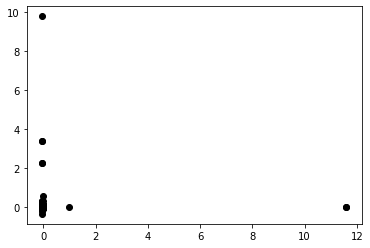

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(transformed_data)):
    plt.scatter(transformed_data[i][0],transformed_data[i][1],c='k')
plt.show()

### Training a 2 Mixture GMM Model



Parameters used
- Number of clusters k
- Maximum iterations for training the GMM Model max_iter
- data_matrix of dimensions (1000 * 10)
- centers :  a dictionary where centers[i] denote the mean of the ith cluster
- cov : the covariance matrix associated with the data points assigned to each cluster


multivariate_normal from scipy is used for getting the PDF value from a normal distribution

In [ ]:
class GMM:
    
    def __init__(self,k,N,data_matrix,max_iter=30):
        self.k = k
        self.d = data_matrix.shape[1]
        self.max_iter = max_iter
        self.data_matrix = data_matrix
        self.colors = ['r','g','b','o','y']
        self.centers = None
        self.cov = None
        self.N = N
        self.pi = None
        self.normal_curves = None
        
        self.labelled_points = None
        
    def initialize(self):
        
        split_points = np.split(self.data_matrix,self.k)
        self.centers = {}
        self.cov = {}
        self.pi = {}
        
        # Split the dataset into K equal parts and compute their mean and covariance for the intial selection
        # of mean and covariance parameters
        
        for i in range(len(split_points)):
            self.centers[i] = np.mean(split_points[i],axis=0)
            
            # Suppress the non diagonal entries
            covariance_matrix = np.cov(split_points[i].transpose()).diagonal()
            diag_cov = np.eye(self.d)
            for k in range(self.d):
                diag_cov[k][k] = covariance_matrix[k]
            
            self.cov[i] = diag_cov
            
            #Initial value of importance given to each gaussian
            self.pi[i] = 1.0/self.k
 

    def plot(self,data_points):
        
        # Plot the scatter plots with colors associated with the gaussian distribution that gave 
        # maximum posterior probability

        for point in data_points:
            plt.scatter(point[0],point[1],c=self.colors[point[2]])
       
        # Black circles denote the projection of the mean vector of each cluster
        for i in range(self.k):
            plt.scatter(self.centers[i][0],self.centers[i][1],c='k')
       
        # Plot the scatter plot
        plt.show()
    
    # The expectation step in the EM Algorithm
    
    def e_step(self):      
        points_to_plot = []
        for i in range(len(self.data_matrix)):
            
            # Compute the posterior probability p(l|x) where l refers to the cluster
            probability = []
            
            
            denominator = 0
            # Denominator term for calculating posterior probabilities
            for k in range(self.k):
                prob_fn = multivariate_normal(self.centers[k],self.cov[k])
                prob = prob_fn.pdf(self.data_matrix[i])
                prob = self.pi[k]*prob
                denominator+=prob
                
            # Doing class conditional likelihood * prior for each class
            for k in range(self.k):
                prob_fn = multivariate_normal(self.centers[k],self.cov[k])
                prob = prob_fn.pdf(self.data_matrix[i])
                prob = (self.pi[k]*prob)/denominator
                probability.append(prob)
           
            # Find the cluster that gives maximum posterior probability
            max_value = max(probability)
            max_index = probability.index(max_value)
            
            points_to_plot.append((self.data_matrix[i][0],self.data_matrix[i][1],max_index))
        
        # The points to be plotted along with their class labels
        self.labelled_points = points_to_plot
        self.plot(points_to_plot)
    
    
    # The Maximization step in EM Algorithm
    def m_step(self):
        
        # Data structures for holding the next set of parameters
        new_pi_k = {}
        new_centers = {}
        new_covs = {}
        
        
        denominator = 0
        for k in range(self.k):
            
        
            # Computing alpha_l for each cluster (Formula used in class)
            s = 0
            for i in range(len(self.data_matrix)):
                
                denominator = 0
                for khat in range(self.k):
                    prob_fn = multivariate_normal(self.centers[khat],self.cov[khat])
                    prob = prob_fn.pdf(self.data_matrix[i])
                    prob = self.pi[khat]*prob
                    denominator+=prob
                
                prob_fn = multivariate_normal(self.centers[k],self.cov[k])
                numerator = prob_fn.pdf(self.data_matrix[i])
                numerator = numerator*self.pi[k]
                s+=(numerator/denominator)
            
            denominator = s
            s = s*(1.0/self.N)
            new_pi_k[k] = s
            #print(new_pi_k)
             
            
            # computing mu_l for each cluster (Formula used in class)
            numerator = None
            for i in range(len(self.data_matrix)):
                
                denom = 0
                for khat in range(self.k):
                    prob_fn = multivariate_normal(self.centers[khat],self.cov[khat])
                    prob = prob_fn.pdf(self.data_matrix[i])
                    prob = self.pi[khat]*prob
                    denom+=prob
                
                prob_fn = multivariate_normal(self.centers[k],self.cov[k])
                
                num = prob_fn.pdf(self.data_matrix[i])
                num = num * self.pi[k]
                num = num * self.data_matrix[i]
                num = num * (1.0/denom)
                
                if numerator is None:
                    numerator = num
                else:
                    numerator = numerator +num
            
            new_centers[k] = numerator*(1.0/denominator)
            
            
            # computing sigma_l for each cluster (Formula used in each class)
            numerator = None
            for i in range(len(self.data_matrix)):
                
                denom = 0
                for khat in range(self.k):
                    prob_fn = multivariate_normal(self.centers[khat],self.cov[khat])
                    prob = prob_fn.pdf(self.data_matrix[i])
                    prob = self.pi[khat]*prob
                    denom+=prob
            
                prob_fn = multivariate_normal(self.centers[k],self.cov[k]) 
                num = prob_fn.pdf(self.data_matrix[i])
                num = num * self.pi[k]
                difference = (self.data_matrix[i] - new_centers[k]).reshape((-1,1))
                num = num * (np.matmul(difference,difference.transpose()))
                num = num * (1.0/denom)
                
                if numerator is None:
                    numerator = num
                else:
                    numerator = numerator +num

            new_covs[k] = numerator*(1.0/denominator)
       
        # Update the parameters for the next step of the EM Algorithm
        self.pi = new_pi_k
        self.centers = new_centers
        self.cov = new_covs
            
    def em_algorithm(self):
        for it in range(self.max_iter):
            print("Iteration " + str(it))
            self.e_step()
            self.m_step()
                  


Iteration 0


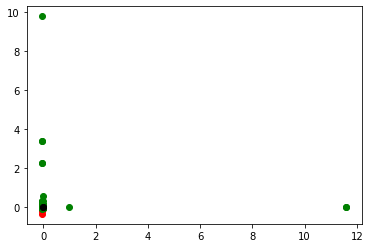

Iteration 1


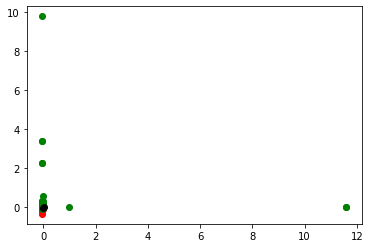

Iteration 2


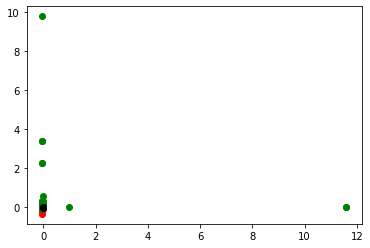

Iteration 3


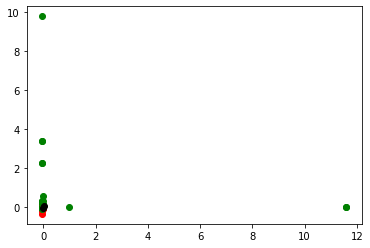

Iteration 4


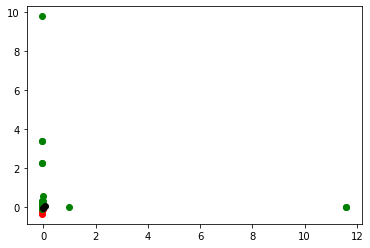

Iteration 5


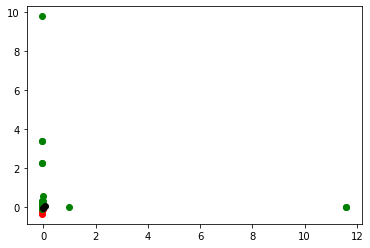

Iteration 6


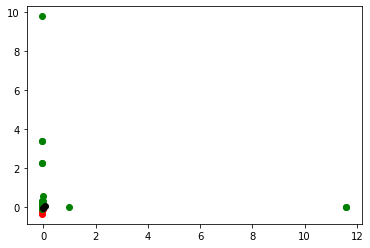

Iteration 7


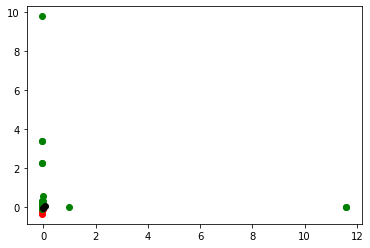

Iteration 8


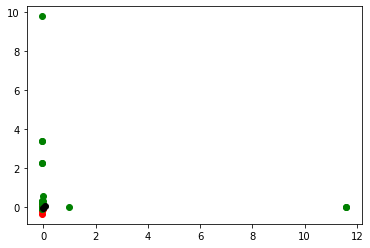

Iteration 9


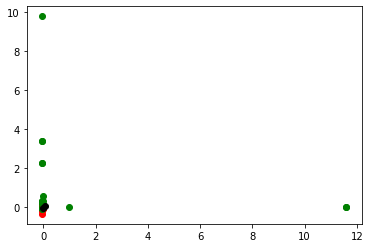

Iteration 10


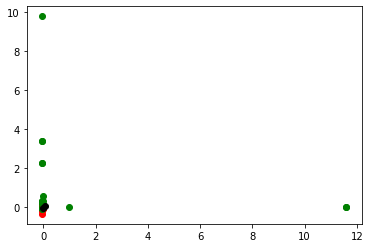

Iteration 11


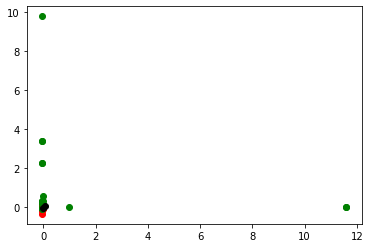

Iteration 12


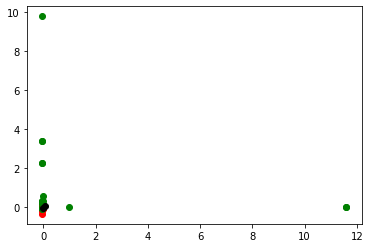

Iteration 13


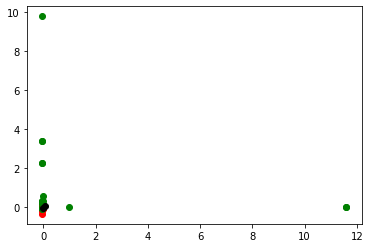

Iteration 14


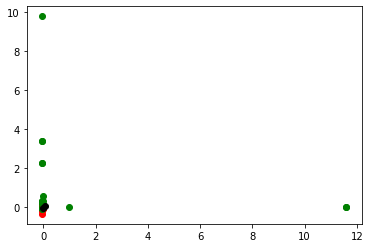

Iteration 15


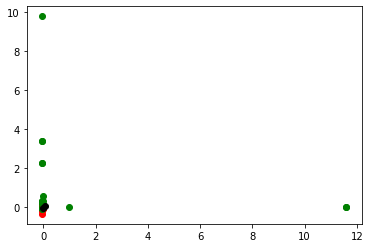

Iteration 16


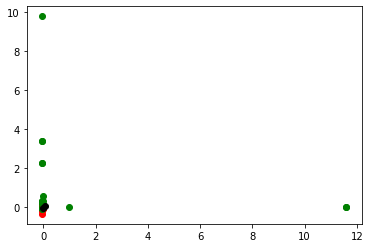

Iteration 17


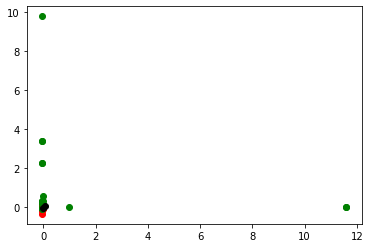

Iteration 18


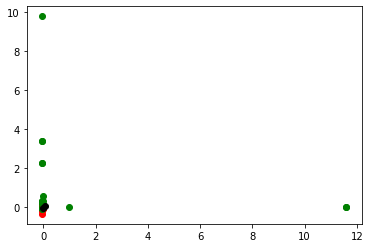

Iteration 19


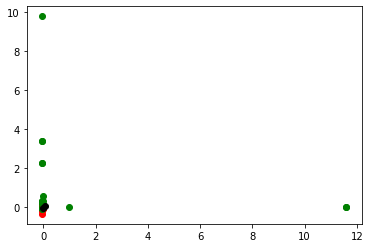

Iteration 20


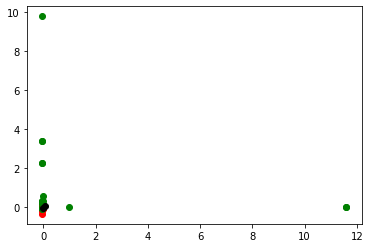

Iteration 21


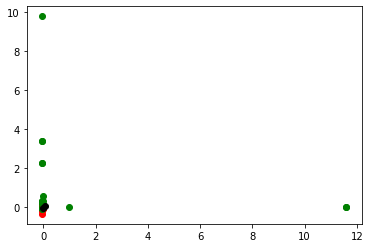

Iteration 22


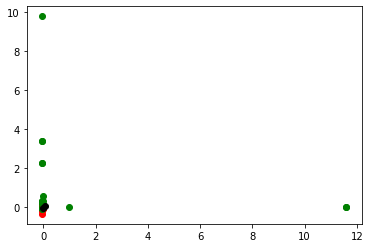

Iteration 23


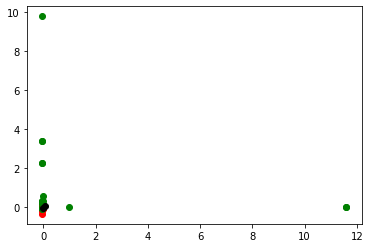

Iteration 24


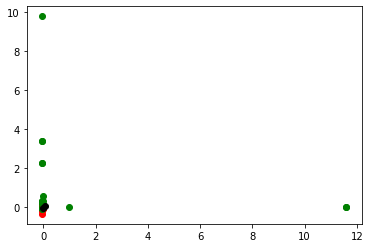

Iteration 25


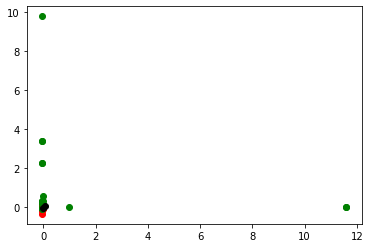

Iteration 26


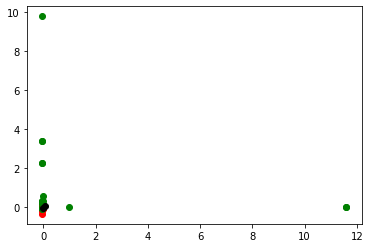

Iteration 27


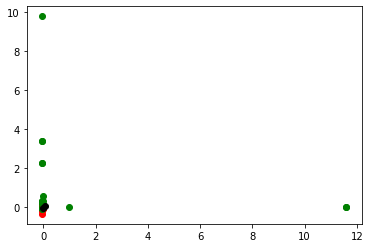

Iteration 28


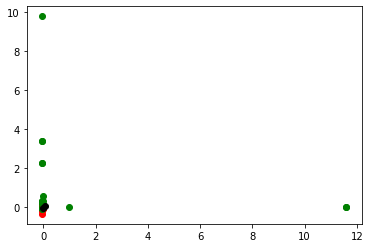

Iteration 29


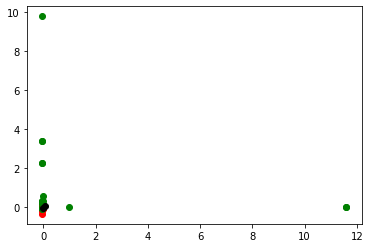

In [ ]:
gmm = GMM(2,1000,transformed_data)
gmm.initialize()
gmm.em_algorithm()

### Checking if the cluster Identity is correlating with the true label for each review

Taking points which are marked with red corresponding to negative sentiment and points which are green to be of positive sentiment

In [ ]:
labelled_points = gmm.labelled_points
count=0
for i in range(len(labels)):
    predicted_cluster = labelled_points[i][2]
    original_class = labels[i]
    if original_class == predicted_cluster:
        count+=1
    
print("Accuracy of cluster Identity  = " + str(float(count)/len(labels)*100))

Accuracy of cluster Identity  = 47.0
